### Preamble

Embeddings in vector space for individual words in TensorFlow

TensorFlow not the most practical implementation of Word2Vec

Gensim better alternative

https://radimrehurek.com/gensim/

# Word2Vec

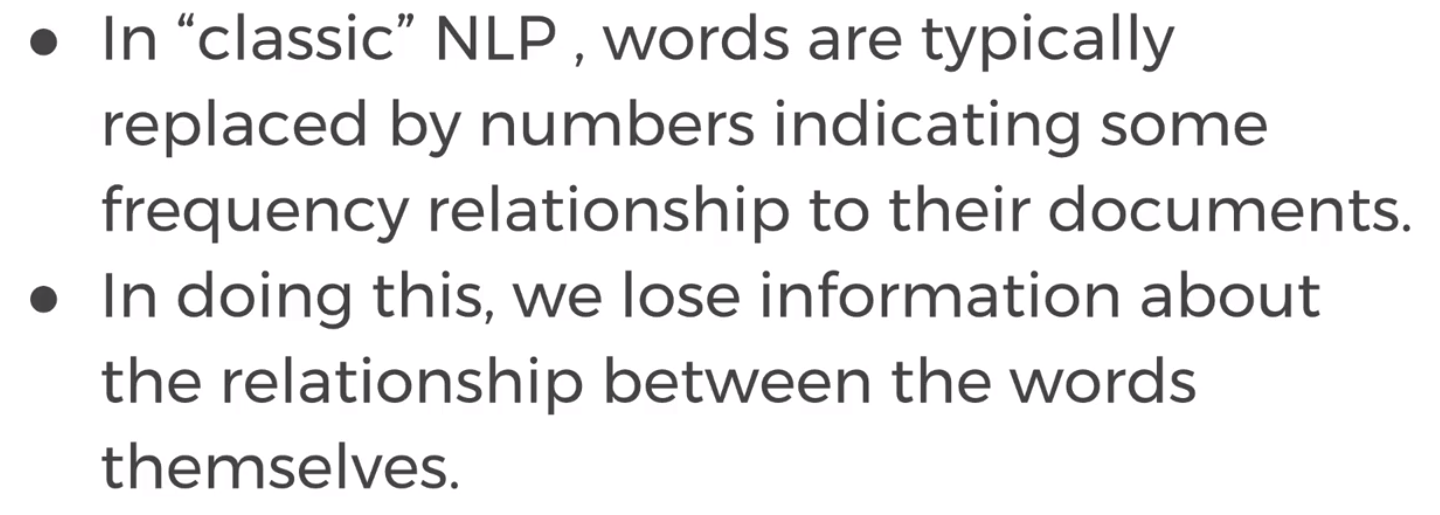

### 2 Approaches for NLP

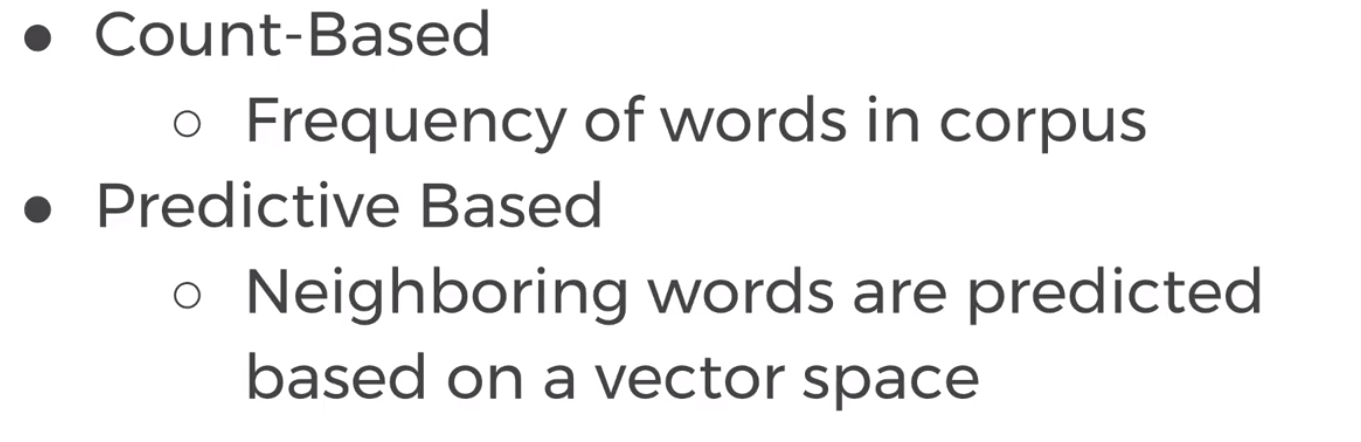

Embed the words into a continuous vector to keep the relationship between the words.

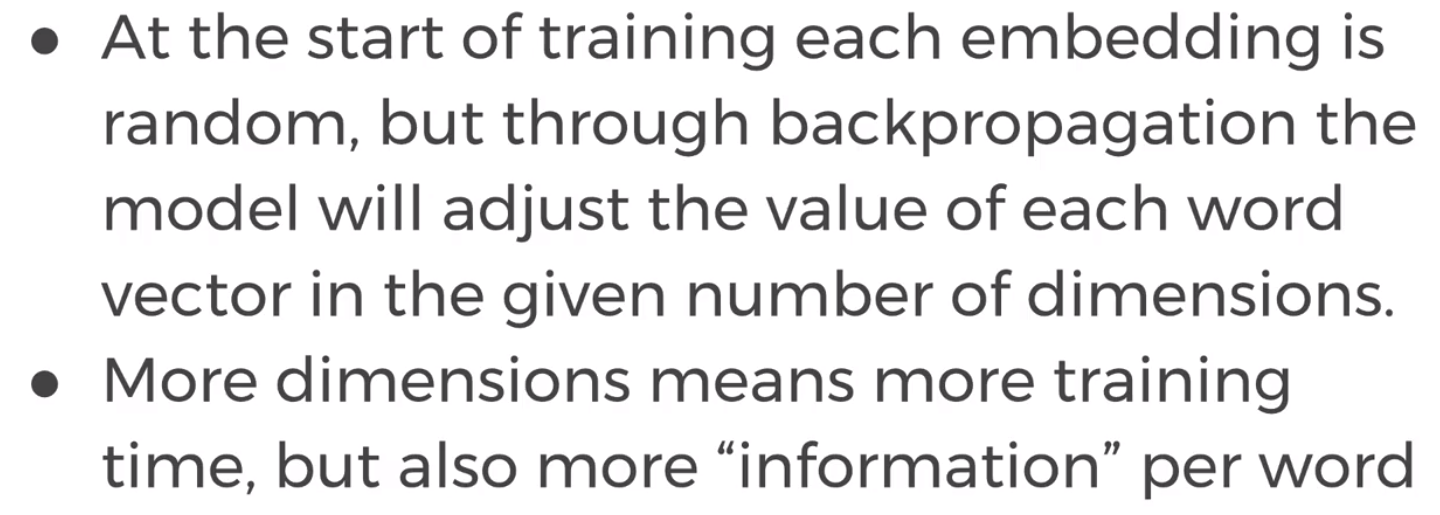

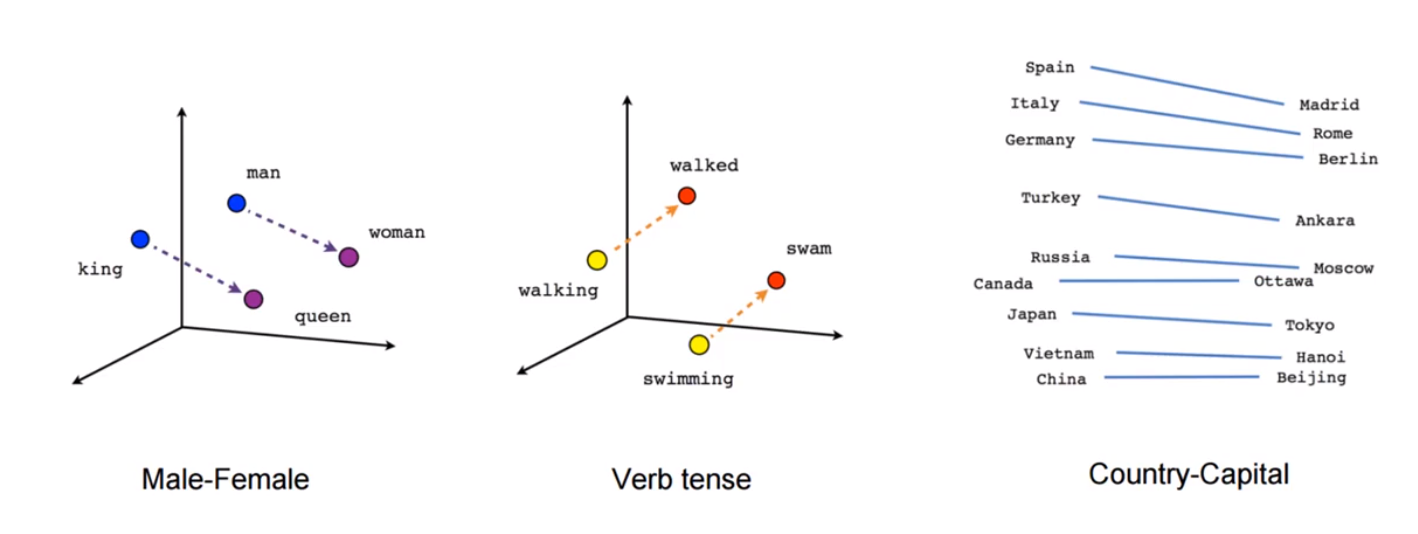

### 2 Models for Word2Vec

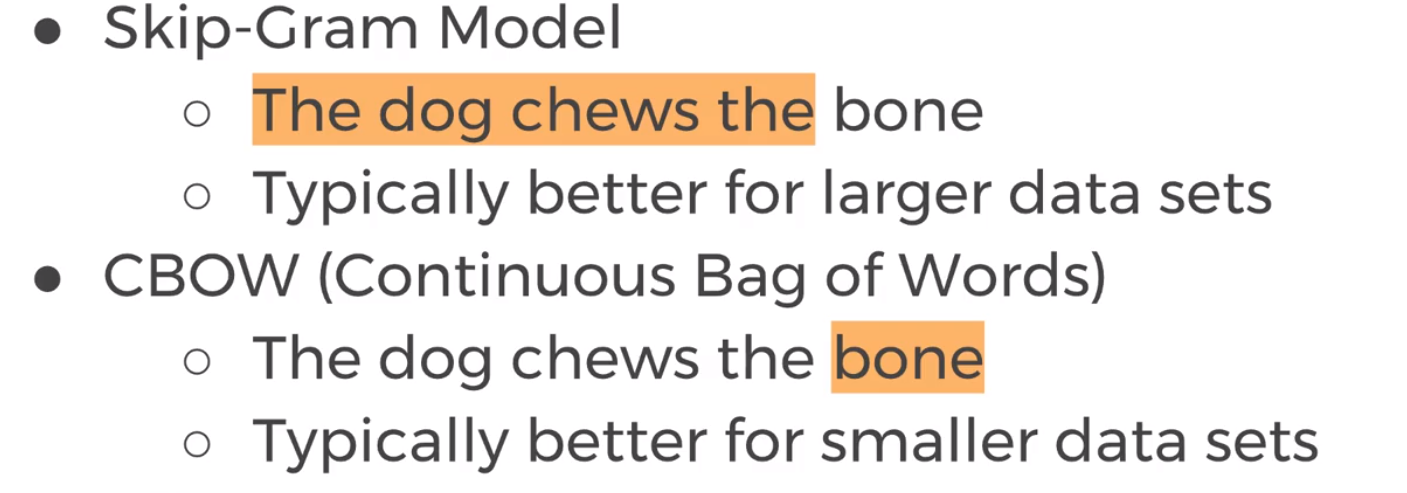

Orange is prediction target based on the context

### Noise-Contrastive Training

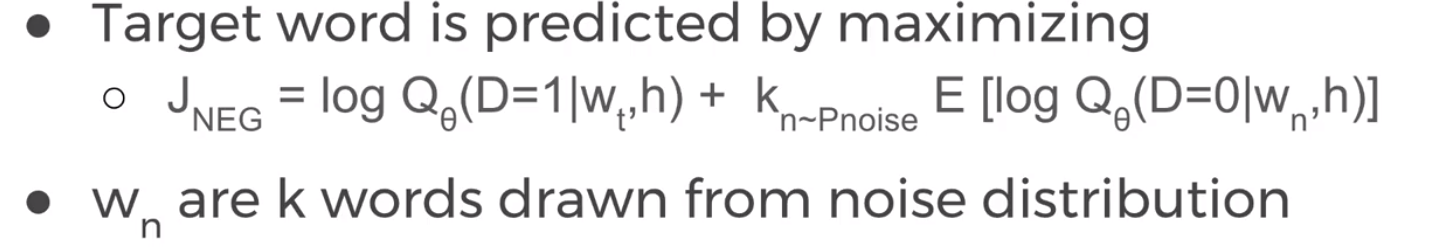

Goal: Assign high probability to correct words and low probability to incorrect words.

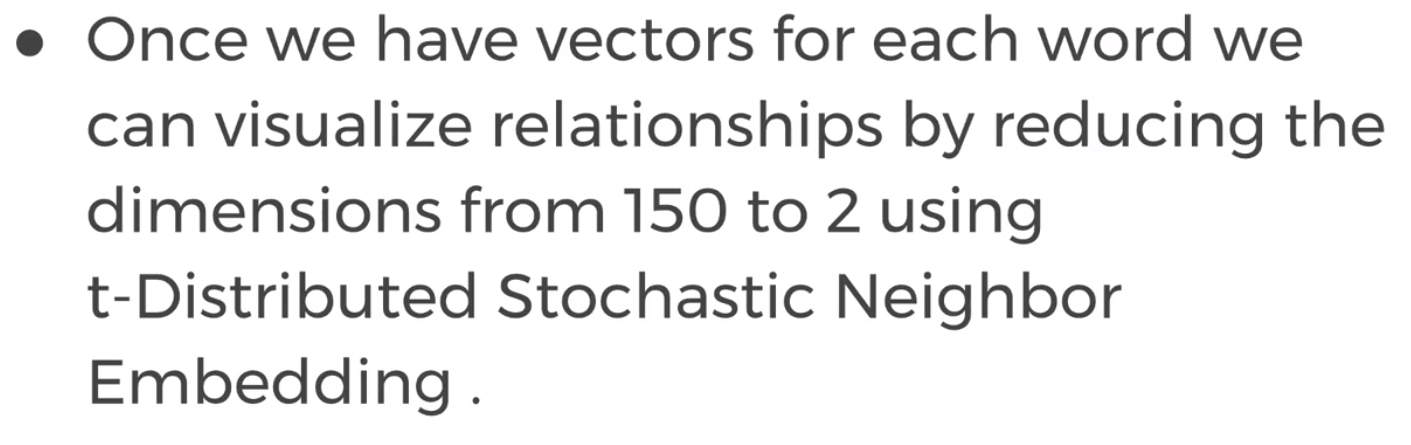

# Word2Vec in Python

In [2]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
os.getcwd()

'C:\\Users\\User\\Desktop\\TensorFlow\\Tensorflow-Bootcamp-master\\04-Recurrent-Neural-Networks'

In [15]:
#os.chdir('./04-Recurrent-Neural-Networks')

In [12]:
#os.chdir('..')

In [17]:
data_dir = "word2vec_data/words"
data_url = "http://mattmahoney.net/dc/text8.zip"

In [21]:
def fetch_words_data(url=data_url, words_data = data_dir):
    
    # Make Dir if no exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Get data from zip file
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
        
    # Return a list of all the words in the data source
    return data.decode("ascii").split()

In [22]:
words = fetch_words_data()

In [23]:
len(words)

17005207

In [24]:
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [25]:
for w in words[10000:10040]:
    print(w,end=' ')

reciprocity qualitative impairments in communication as manifested by at least one of the following delay in or total lack of the development of spoken language not accompanied by an attempt to compensate through alternative modes of communication such as gesture 

Punctuations have all been removed

In [26]:
from collections import Counter

In [27]:
my_list = ['one','two','two']

In [28]:
Counter(my_list)

Counter({'one': 1, 'two': 2})

In [29]:
Counter(my_list).most_common(1)

[('two', 2)]

In [30]:
Counter(words[1200:12060]).most_common(5)

[('the', 547), ('of', 386), ('and', 312), ('in', 272), ('to', 259)]

In [32]:
def create_counts(vocab_size=50000):
    
    vocab = [] + Counter(words).most_common(vocab_size)
    
    # _ is used to throw something away in tuple unpacking
    vocab = np.array([word for word, _ in vocab])
    
    dictionary = {word:code for code, word in enumerate(vocab)}
    
    data = np.array([dictionary.get(word,0) for word in words])
    
    return data, vocab

In [34]:
data, vocabulary = create_counts()

In [39]:
words[100]

'interpretations'

In [40]:
data[100]

4186

In [41]:
words[0:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [45]:
data[0:10]

array([5233, 3080,   11,    5,  194,    1, 3133,   45,   58,  155])

### Function for Batchs

Directly taken from the word2vec TensorFlow documentation

In [44]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

### CONSTANTS

In [108]:
batch_size = 128

# embedding size is the number of dimensions in the embedding vector
embedding_size = 150

skip_window = 1

num_skips = 2

In [109]:
valid_size = 16

In [110]:
valid_window = 100
valid_examples = np.random.choice(valid_window,valid_size,replace=False)

In [111]:
num_sampled = 64

In [112]:
learning_rate = 0.01

In [113]:
vocabulary_size = 50000

### Placeholders

In [114]:
tf.reset_default_graph()

In [115]:
train_inputs = tf.placeholder(tf.int32,shape=[None])
train_labels = tf.placeholder(tf.int32,shape=[batch_size, 1])

valid_dataset = tf.constant(valid_examples,dtype=tf.int32)

### Variables

In [116]:
init_embeds = tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0)

In [117]:
#init_embeds

In [118]:
embeddings = tf.Variable(init_embeds)

In [119]:
embed = tf.nn.embedding_lookup(embeddings,train_inputs)

### Loss Function

In [120]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0/np.sqrt(embedding_size)))
nce_bias = tf.Variable(tf.zeros([vocabulary_size]))

In [121]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_bias, train_labels, embed,
                   num_sampled, vocabulary_size))

### Optimizer

In [122]:
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [123]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),axis=1,keepdims=True))
normalized_embeddings = embeddings/norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)
similarity = tf.matmul(valid_embeddings,normalized_embeddings,transpose_b=True)

In [124]:
data_index = 0

In [125]:
init = tf.global_variables_initializer()

### Run Sesssion

In [126]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [127]:
num_steps = 20000

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(init)
    average_loss = 0
    
    for step in range(num_steps):
        
        batch_inputs, batch_labels = generate_batch(batch_size,num_skips,skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels:batch_labels}
        
        _,loss_val = sess.run([trainer,loss],feed_dict=feed_dict)
        
        average_loss += loss_val
        
        if step % 1000 == 0:
            if step > 0:
                average_loss/1000
            print("Average Loss at step ",step,"is: ",average_loss)
            average_loss = 0
            
        final_embeddings = normalized_embeddings.eval()

Average Loss at step  0 is:  292.85540771484375
Average Loss at step  1000 is:  11376406.745819092
Average Loss at step  2000 is:  22370847.413101196
Average Loss at step  3000 is:  26573690.10282898
Average Loss at step  4000 is:  30854244.40478134
Average Loss at step  5000 is:  35132384.52200563
Average Loss at step  6000 is:  38557183.84482002
Average Loss at step  7000 is:  39048204.59384858
Average Loss at step  8000 is:  44545857.08598995
Average Loss at step  9000 is:  42575766.901622415
Average Loss at step  10000 is:  46242346.50411463
Average Loss at step  11000 is:  44917224.03913015
Average Loss at step  12000 is:  47135639.94044304
Average Loss at step  13000 is:  49872973.363184914
Average Loss at step  14000 is:  42666019.541327
Average Loss at step  15000 is:  45178976.1003294
Average Loss at step  16000 is:  45371345.30920166
Average Loss at step  17000 is:  42572999.61353111
Average Loss at step  18000 is:  43345218.67458689
Average Loss at step  19000 is:  43929282.

### Visualize Results

In [130]:
final_embeddings.shape

(50000, 150)

### t-distributed Stochastic Neighbour Embedding

In [142]:
from sklearn.manifold import TSNE

Project the 50000 dimensions onto 2 dimensions to visualize

In [153]:
tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000)

In [154]:
plot_only = 2000

In [155]:
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [156]:
labels = [vocabulary[i] for i in range(plot_only)]

In [157]:
low_dim_embed.shape

(2000, 2)

In [158]:
import matplotlib.pyplot as plt
% matplotlib inline

In [161]:
def plot_with_labels(low_dim_embed,labels):
    assert low_dim_embed.shape[0] >= len(labels)
    plt.figure(figsize=(60,60))
    for i,label in enumerate(labels):
        x,y = low_dim_embed[i,:]
        plt.scatter(x,y)
        plt.annotate(label,
                    xy = (x,y),
                    xytext = (5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')

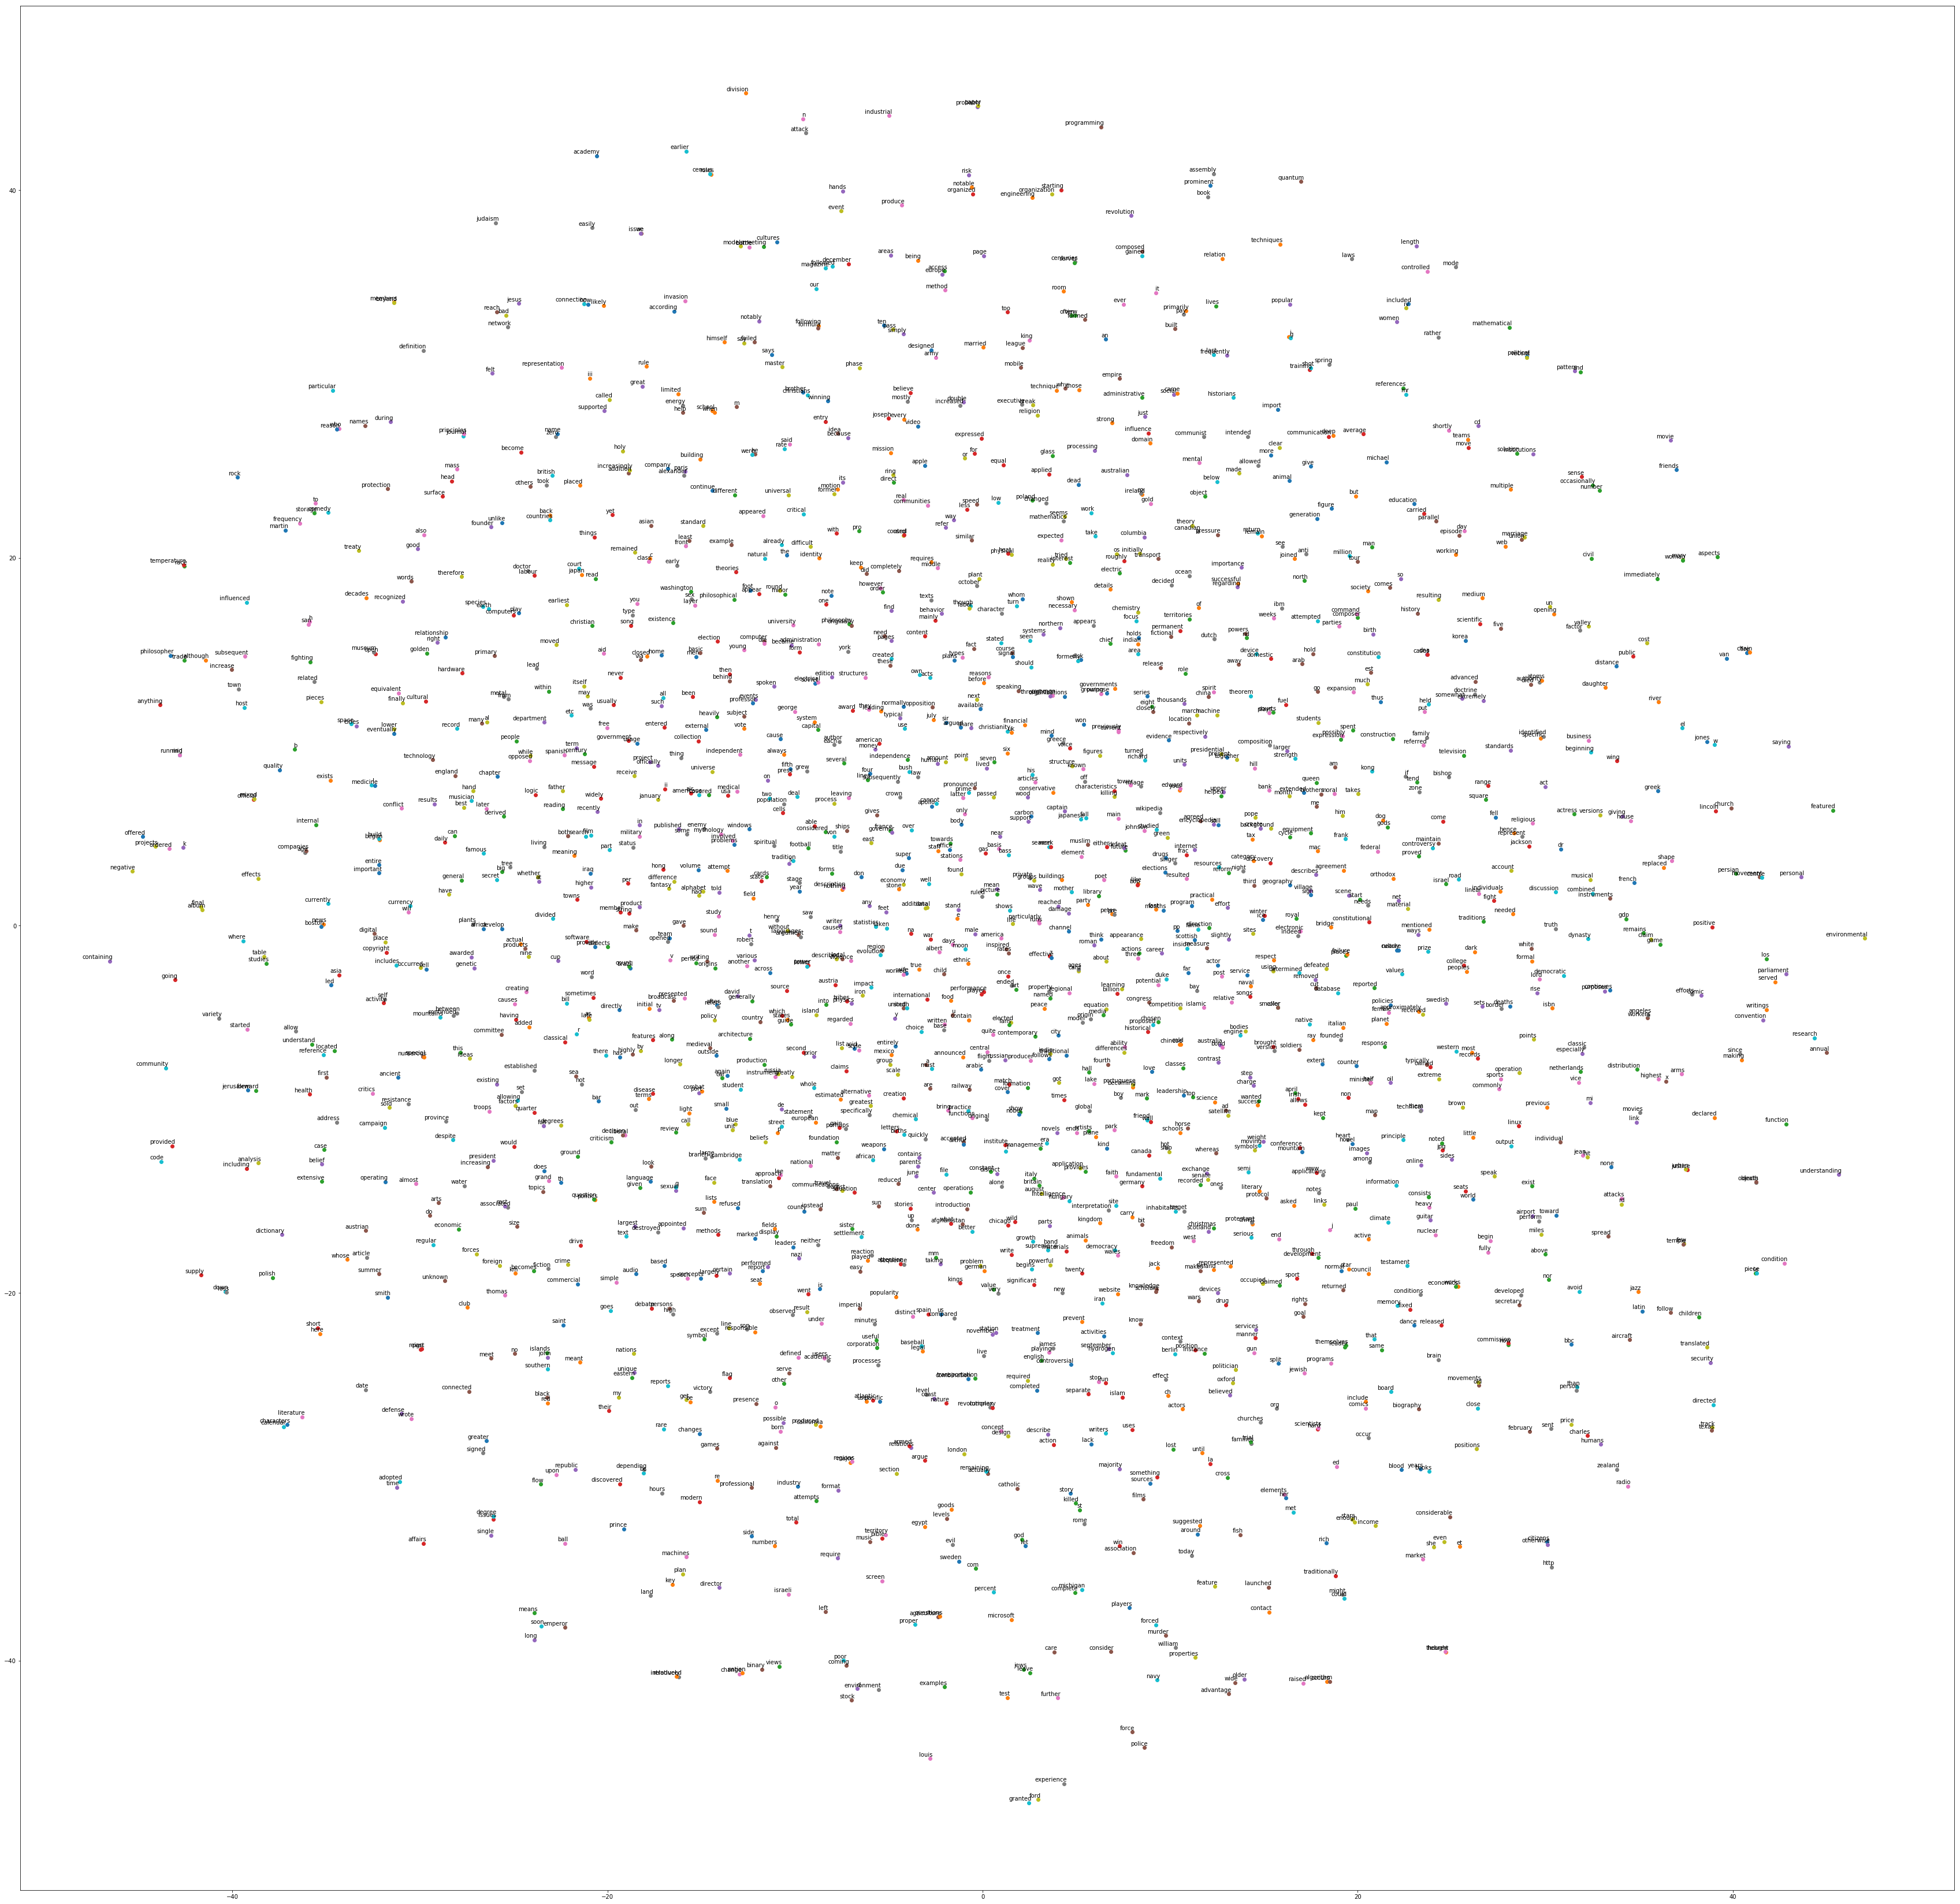

In [162]:
plot_with_labels(low_dim_embed,labels)

In [152]:
final_embeddings = np.load("trained_embeddings_200k_steps.npy")